# 🧠 MLP Models for Drug Sensitivity Prediction

This notebook trains a **Multi-layer Perceptron (MLP)** regression model for each drug in the GDSC dataset using gene expression features (PCA or HVGs). Models are trained to predict `LN_IC50` values for each (cell line, drug) pair.

We use **5-fold cross-validation** to get stable metrics for each model.


In [1]:
# %%
import os
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer
from sklearn.base import clone

import matplotlib.pyplot as plt
import seaborn as sns

# Robust RMSE scorer that works across sklearn versions
try:
    from sklearn.metrics import root_mean_squared_error as _rmse
    def _rmse_metric(y_true, y_pred):
        return _rmse(y_true, y_pred)
except Exception:
    from sklearn.metrics import mean_squared_error
    def _rmse_metric(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(_rmse_metric, greater_is_better=False)


In [3]:
# %%
# Choose your input dataset
DATA_PATH = "../../../data/processed/bulk_with_pca.parquet"

data = pd.read_parquet(DATA_PATH)
print("✅ Dataset loaded:", data.shape)


✅ Dataset loaded: (571985, 33)


### 🔁 Training One MLP per Drug

Each model is trained using **5-fold cross-validation** to estimate generalization performance.  
We record the mean and standard deviation of both RMSE and R² scores.


In [4]:
# %%

# Define features (assumes PCA/HVG columns are all non-metadata columns)
non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [c for c in data.columns if c not in non_features]

if len(gene_cols) == 0:
    raise ValueError("No feature columns detected. Check `non_features` and your dataframe schema.")

# CV config
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Models ---
# CV model: smaller net, strong L2, LBFGS (stable on small folds); no early stopping during CV
cv_pipe = Pipeline([
    ("scaler_x", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(32,),
        activation="tanh",
        alpha=0.10,          # try {0.01, 0.1, 1.0} if sweeping
        solver="lbfgs",
        max_iter=5000,
        random_state=42,
    ))
])
cv_model = TransformedTargetRegressor(
    regressor=cv_pipe,
    transformer=StandardScaler()  # scale y as well
)

# Final refit model on all data: Adam + early stopping (ONLY for the final fit)
final_pipe = Pipeline([
    ("scaler_x", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(32,),
        activation="tanh",
        alpha=0.10,
        solver="adam",
        learning_rate="adaptive",
        early_stopping=True,
        validation_fraction=0.20,
        n_iter_no_change=50,
        max_iter=5000,
        random_state=42,
    ))
])
final_model_template = TransformedTargetRegressor(
    regressor=final_pipe,
    transformer=StandardScaler()
)

MIN_SAMPLES = 30  # raise threshold; neural nets struggle below this
results = []

unique_drugs = sorted(data["DRUG_ID"].dropna().unique())
print(f"Found {len(unique_drugs)} drugs.\n")

for drug_id in unique_drugs:
    # Drop rows with any NaNs in features or target
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=gene_cols + ["LN_IC50"])
    n = df.shape[0]
    if n < MIN_SAMPLES:
        print(f"⏭️  Drug {drug_id}: only {n} samples (min={MIN_SAMPLES}). Skipping.")
        continue

    X = df[gene_cols].to_numpy(dtype=float)
    y = df["LN_IC50"].to_numpy(dtype=float)

    # Cross-validated metrics (negative RMSE -> flip sign for reporting)
    rmse_scores = cross_val_score(cv_model, X, y, scoring=rmse_scorer, cv=kf, n_jobs=-1)
    r2_scores   = cross_val_score(cv_model, X, y, scoring="r2",            cv=kf, n_jobs=-1)

    rmse_mean = -rmse_scores.mean()
    rmse_std  = rmse_scores.std()
    r2_mean   = r2_scores.mean()
    r2_std    = r2_scores.std()

    print(f"\n🧠 Drug {drug_id} | Samples: {n}")
    print(f"  ➤ RMSE (folds): {(-rmse_scores).round(4)} | Mean: {rmse_mean:.4f} ± {rmse_std:.4f}")
    print(f"  ➤ R²   (folds): {r2_scores.round(4)}    | Mean: {r2_mean:.4f} ± {r2_std:.4f}")

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": n,
        "rmse_mean": rmse_mean,
        "rmse_std": rmse_std,
        "r2_mean": r2_mean,
        "r2_std": r2_std
    })

    # Final fit on ALL data with early stopping + Adam
    model = clone(final_model_template)
    model.fit(X, y)



Found 697 drugs.


🧠 Drug 1 | Samples: 391
  ➤ RMSE (folds): [1.4977 1.4036 1.4594 1.4503 1.3793] | Mean: 1.4381 ± 0.0420
  ➤ R²   (folds): [-0.2113 -1.7913 -0.5825 -0.8282 -0.8345]    | Mean: -0.8496 ± 0.5227

🧠 Drug 3 | Samples: 356
  ➤ RMSE (folds): [2.872  2.3213 2.7764 2.9035 2.8015] | Mean: 2.7349 ± 0.2119
  ➤ R²   (folds): [-1.2766 -0.5846 -0.9032 -1.0065 -0.6784]    | Mean: -0.8899 ± 0.2455

🧠 Drug 5 | Samples: 394
  ➤ RMSE (folds): [2.2294 2.0128 2.1692 2.109  2.0522] | Mean: 2.1145 ± 0.0780
  ➤ R²   (folds): [-0.9016 -0.5776 -0.1991 -0.8847 -1.1958]    | Mean: -0.7518 ± 0.3385

🧠 Drug 6 | Samples: 403
  ➤ RMSE (folds): [1.3822 1.2672 1.1095 1.3525 1.3351] | Mean: 1.2893 ± 0.0975
  ➤ R²   (folds): [-0.5981 -1.994  -0.452  -2.2546 -1.1936]    | Mean: -1.2985 ± 0.7233

🧠 Drug 9 | Samples: 396
  ➤ RMSE (folds): [2.1618 2.273  2.0339 2.0522 1.9413] | Mean: 2.0924 ± 0.1143
  ➤ R²   (folds): [-0.9875 -1.4306 -1.1802 -0.8214 -0.8863]    | Mean: -1.0612 ± 0.2210

🧠 Drug 11 | Samples: 

In [5]:
os.makedirs("results/mlp", exist_ok=True)

results_df = pd.DataFrame(results)
results_df.to_csv("results/mlp/voom_30_pcs.csv", index=False)

print("📁 Saved to models_mlp/model_performance_summary.csv")
results_df.head()


📁 Saved to models_mlp/model_performance_summary.csv


,DRUG_ID,n_samples,rmse_mean,rmse_std,r2_mean,r2_std
0,1,391,1.438059,0.041970,-0.849558,0.522735
1,3,356,2.734944,0.211894,-0.889852,0.245463
2,5,394,2.114525,0.078015,-0.751757,0.338528
3,6,403,1.289295,0.097488,-1.298459,0.723304
4,9,396,2.092420,0.114274,-1.061200,0.220989


### 📈 Distribution of RMSE and R² Scores (MLP Models)

These histograms show how model performance varies across drugs. Lower RMSE and higher R² indicate better prediction of drug sensitivity (IC50 values) for a given cell line.


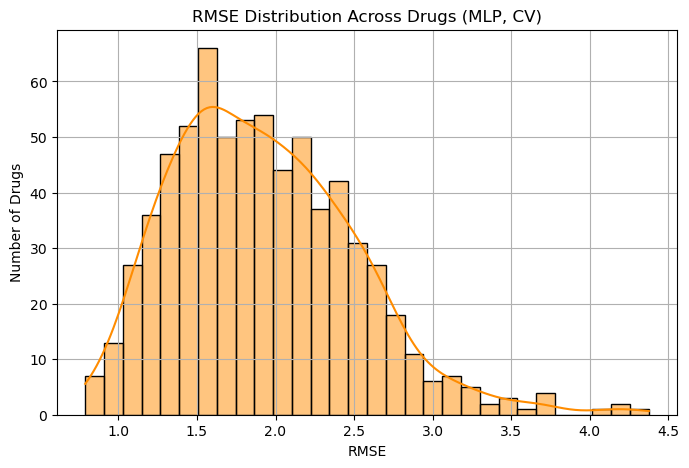

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
plt.title("RMSE Distribution Across Drugs (MLP, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()

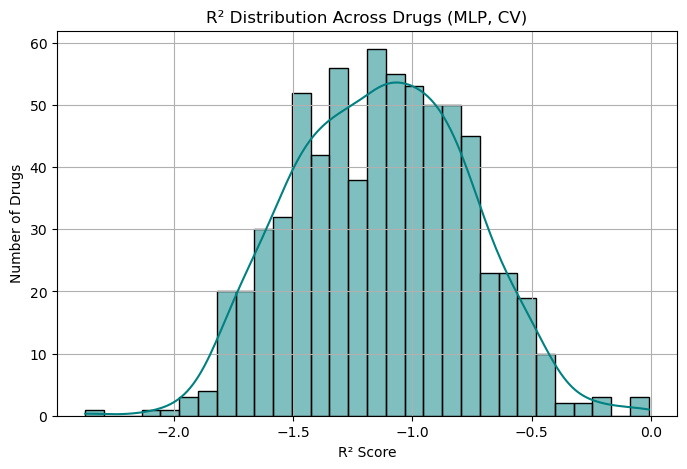

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
plt.title("R² Distribution Across Drugs (MLP, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()